# Goal: Visualize 2D Convolutions


The concept of a convolution is fundamental to understanding modern deep network architectures (indeed, the success of deep convnets in object recognition was arguably the major driver in kickstarting the current wave of AI starting from the early 2010s).

But convolution can be quite tricky to internalize, particularly when taught from a mathematical viewpoint. This short tutorial is non-mathematical in its treatment, and instead presents a visualization of 2D convolution of an input image with various filters. We will explore both filtering and pooling, both of which are commonly used operations in convnets.

The image below shows the overall idea of a convolution:
- An input image $\mathbf{I}$
- A filter (or kernel) $\mathbf{K}$
- The output $\mathbf{I} \ast \mathbf{K}$

![conv](https://tikz.net/janosh/conv2d.png)

Each output pixel in $\mathbf{I} \ast \mathbf{K}$ is calculated by performing an element-wise multiplication of the $3 \times 3$ kernel weights with the image pixel values for a particular $3 \times 3$ patch of the image and summing the output. There are two key points to note here:
- *Locality*: Each output pixel only depends on a small local neighborhood of input pixels.
- *Shift Invariance*: The weights of the filter remain the same no matter whether one is computing the first output pixel, or the second, or anywhere in the output.

As a final note, compare the size of the input image ($7\times 7$) to size of the output image ($5\times 5$). Reason why this is the case by counting the number of possible windows to place our kernel on the input image.


To get started with visualizing, let's import our favorite libraries.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objs as go   # we will be using plotly to create interactive, 3-D plots
from plotly.offline import iplot

As visualization examples we will use the MNIST dataset. We will first convert our images to Torch tensors and normalize the images.

In [5]:
mean = 0.13066
std = 0.30810
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = [mean], std = [std])])
test_data = torchvision.datasets.MNIST('./MNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

Let's work with 5 images from the test dataset. 

In [6]:
num_images = 5
images = []

for i in range(num_images):
    image, label = test_data[i]
    images.append(image)

images = torch.cat([img.unsqueeze(0) for img in images], dim=0) # convert list of tensors to tensor
print(images.shape)

torch.Size([5, 1, 28, 28])


We can see that the output `shape` of our Torch Tensor containing the images is $ B \times C \times H \times W$ where:
- $B$ is the batch size
- $C$ is the number of channel (this value is 1 in our case since we are working with gray images)
- $H$ is the height of the image
- $W$ is the width of the image

Let's create a function to plot the original images and the images after applying the convolution for a particular fitler.

In [7]:
def plot_filter(images, filtered_images):
    
    n_images = images.shape[0]

    fig = plt.figure(figsize = (20, 5))
    
    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap = 'bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title(f'Output')
        ax.axis('off');    

In deep learning, **the weights of the filter are learned using backpropagation, but for the purpose of this demo, we will fix the filter weights and observe what happens after applying the convolution to our images**. 

We will be making using of [`torch.nn.functional.conv2d`](https://pytorch.org/docs/stable/nn.functional.html) that takes as input a batch of images and a filter. I encourage you to check out the documentation to see what the appropriate shapes for the inputs to the `conv2d` function are.

## All-Ones $2\times 2$ Kernel
 
To illustrate, let's start a with a small $2\times 2$ filter with all ones.

Size of Original Image: torch.Size([1, 28, 28])
Size of Kernel/Filter : torch.Size([2, 2])
Size of Filtered Image: torch.Size([1, 27, 27])


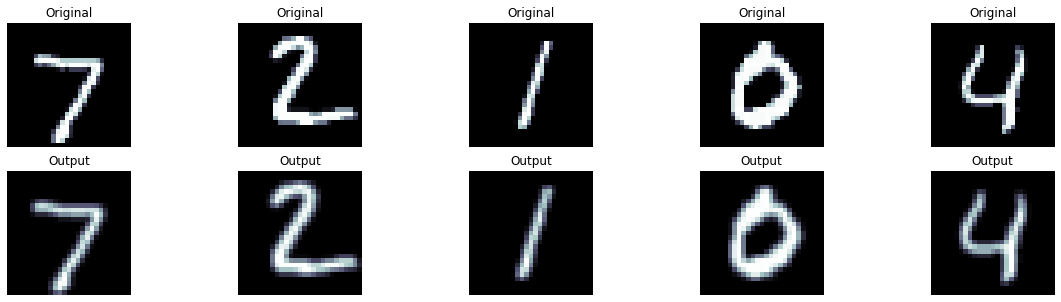

In [8]:
filter = [[1,1],
          [1,1]]

filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0) # converting to the appropriate shape

filtered_images = F.conv2d(images, filter)
print("Size of Original Image:", images[0].shape)
print("Size of Kernel/Filter :", filter[0,0].shape)
print("Size of Filtered Image:", filtered_images[0].shape)
plot_filter(images, filtered_images)

Hmm, can't really see much here (although the outputs look slightly grayer than the inputs). As we observed with the image at the beginning of the notebook, we see that the size of the output decreased! Again, reason why this is the case by counting the number of possible windows in the input image with respect to the size of the filter we just used.

## All-Ones $5\times 5$ Kernel

What if we increase the size of the filter?

Size of Original Image: torch.Size([1, 28, 28])
Size of Kernel/Filter : torch.Size([5, 5])
Size of Filtered Image: torch.Size([1, 24, 24])


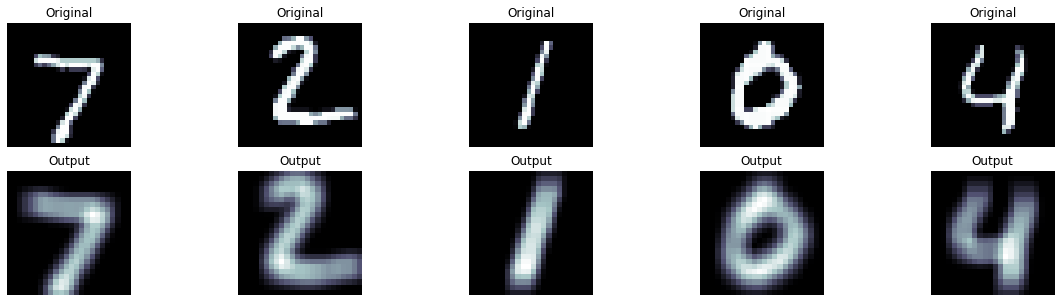

In [9]:
filter = [[1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1]
          ]
filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0)

filtered_images = F.conv2d(images,filter)
print("Size of Original Image:", images[0].shape)
print("Size of Kernel/Filter :", filter[0,0].shape)
print("Size of Filtered Image:", filtered_images[0].shape)
plot_filter(images, filtered_images)

The effect is now much more visible. And the size of our output image is even smaller when compared to the $2\times 2$ case as there are fewer windows in the input image to place our $5 \times 5$ kernel.

The all-ones filter smears out values of the input, therefore producing blurry image outputs. Play around with different filter sizes to see what happens. At what point does the output become completely unrecognizable?

To get an interactive plot for the "4" image, try running the following two lines of code in separate cells:
```
go.Figure(data=[go.Surface(z=images[-1,0].T.tolist())])
```

```
go.Figure(data=[go.Surface(z=filtered_images[-1,0].T.tolist())])
```

As an exercise, compare the minimum and maximum values in input and output tensors. What's happened after applying our all-ones filter?

## Horizontal Edge Detector $2\times 2$ Kernel

Let us now try a different filter. This time, our filter will have some negative values.

Size of Original Image: torch.Size([1, 28, 28])
Size of Kernel/Filter : torch.Size([2, 2])
Size of Filtered Image: torch.Size([1, 27, 27])


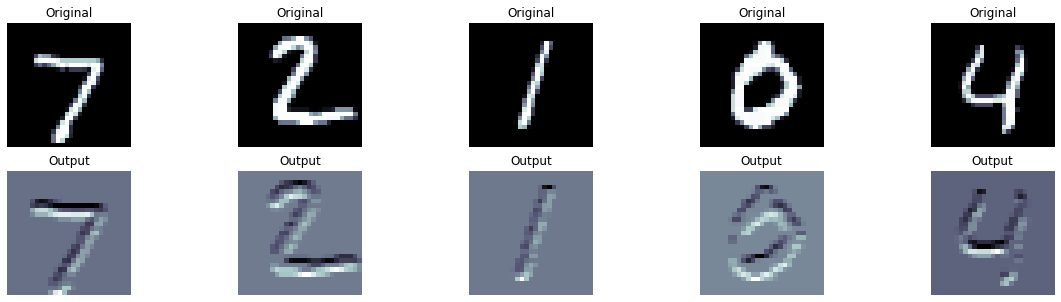

In [10]:
filter = [[1,1],
          [-1, -1]]

filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0)

filtered_images = F.conv2d(images,filter)
print("Size of Original Image:", images[0].shape)
print("Size of Kernel/Filter :", filter[0,0].shape)
print("Size of Filtered Image:", filtered_images[0].shape)
plot_filter(images, filtered_images)

Interesting. If you stare carefully, features that are vertical (such as most of the 1, or the left side of the 0, or the stalk of the 4) have been grayed out, while features that are *horizontal* (such as the bar of the 7, or the bar of the 4) are bright. This particular filter is a type of *horizontal edge detector*. Note that in the case of the 7, the "top" of the horizontal bar has lower pixel values than the bottom of the horizontal bar. Let's flip our kernel and see what happens.

Size of Original Image: torch.Size([1, 28, 28])
Size of Kernel/Filter : torch.Size([2, 2])
Size of Filtered Image: torch.Size([1, 27, 27])


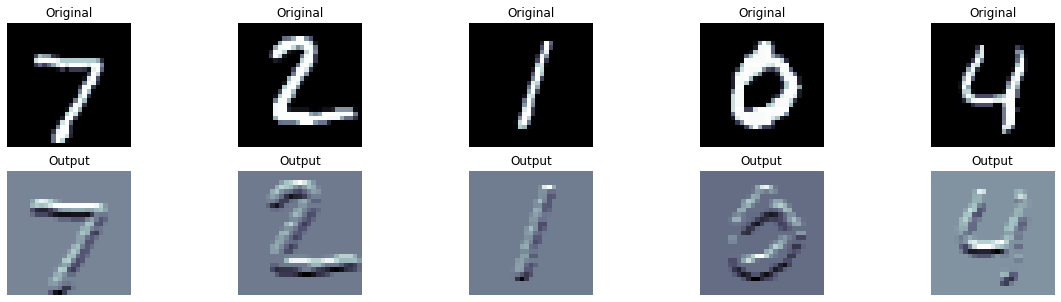

In [11]:
filter = [[-1,-1],
          [1, 1]]

filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0)

filtered_images = F.conv2d(images,filter)
print("Size of Original Image:", images[0].shape)
print("Size of Kernel/Filter :", filter[0,0].shape)
print("Size of Filtered Image:", filtered_images[0].shape)
plot_filter(images, filtered_images)

For the output images, now the top of the horizontal bar has higher pixel values than the bottom part of the bar. Given the filter values, can you see why?

## Horizontal Edge Detector $3\times 3$ Kernel

The edge-detecting effect is slightly more pronounced if we use 3x3 filters.

Size of Original Image: torch.Size([1, 28, 28])
Size of Kernel/Filter : torch.Size([3, 3])
Size of Filtered Image: torch.Size([1, 26, 26])


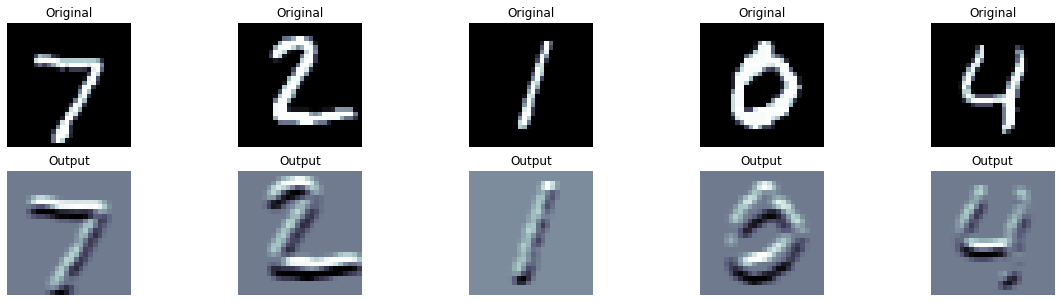

In [12]:
filter = [[-1,-2,-1],
          [0,0,0],
          [1,2,1]]
filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0)

filtered_images = F.conv2d(images,filter)
print("Size of Original Image:", images[0].shape)
print("Size of Kernel/Filter :", filter[0,0].shape)
print("Size of Filtered Image:", filtered_images[0].shape)
plot_filter(images, filtered_images) 

See if you can get better edge detection using other filters. Play around also with the direction; how would you detect vertical edges?

## Average Pooling
Let us now also examine pooling. This is related to filtering, and is used to reduce the resolution (size) of the input image. Like convolution, this also happens by operating on windows of the input; the difference, however, is that we now use a *stride*, i.e., we skip over certain windows. For example, with stride = 2, we skip computing the output of every 2nd window; this means that the output is (approximately, barring fence effects) half the size of the input. 

Let's look at average pooling which simply averages the pixels over the specified kernel size. We will use Torch's built-in [`avg_pool2d`](https://pytorch.org/docs/stable/nn.functional.html#pooling-functions) function. Checking out the documentation, we see that Torch will set the stride to the kernel size.

Size of Original Image: torch.Size([1, 28, 28])
Size of Filtered Image: torch.Size([1, 9, 9])


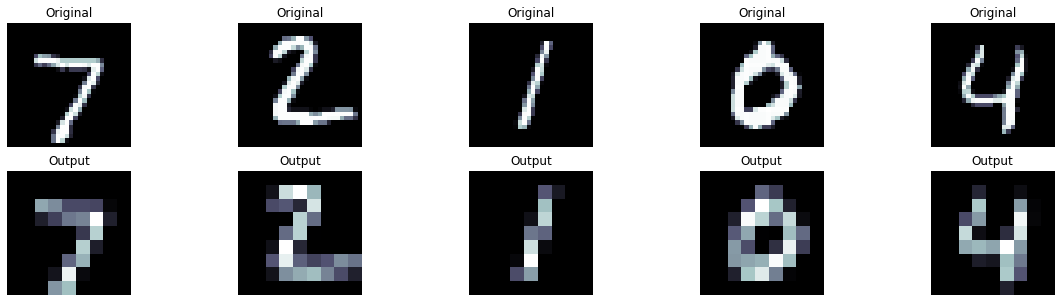

In [13]:
pooled_images = F.avg_pool2d(images,kernel_size=3)
print("Size of Original Image:", images[0].shape)
print("Size of Filtered Image:", pooled_images[0].shape)
plot_filter(images, pooled_images)

As visually evident, the output looks blocky and is grayed out. Also, since our kernel (and thus stride) size is equal to 3, the resolution of our output image is $\sim 1/3$ the resolution of the input image.

We can also implement the average pooling function using the convolution function provided by torch. For a $3x3$ window of our input image, we want each pixel value to contribute a weight of $1/9$ of its value to the final value of the output pixel (since we are averaging over 9 values). We also need to remember to set the stride to 3.

In [14]:
filter = [[1,1,1,],
          [1,1,1],
          [1,1,1]]

filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0)
filter = filter / 9 
print(filter)

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


So each weight of our $3\times 3$ kernel is set to $1/9$.

Size of Original Image: torch.Size([1, 28, 28])
Size of Kernel/Filter : torch.Size([3, 3])
Size of Filtered Image: torch.Size([1, 9, 9])


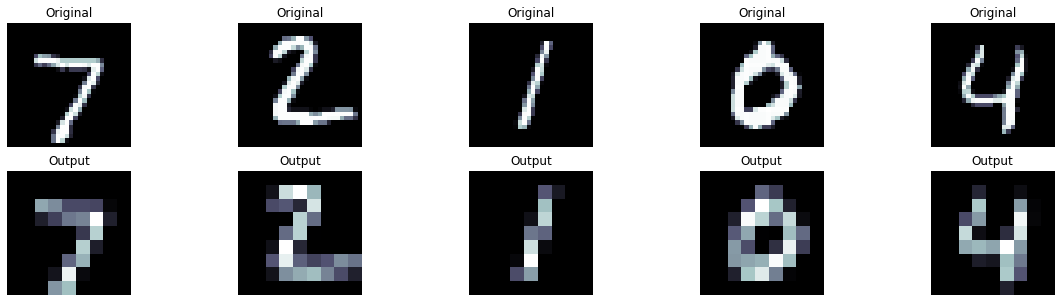

In [15]:
filtered_images = F.conv2d(images, filter, stride=3)
print("Size of Original Image:", images[0].shape)
print("Size of Kernel/Filter :", filter[0,0].shape)
print("Size of Filtered Image:", filtered_images[0].shape)
plot_filter(images, filtered_images)

As a sanity check, let's confirm that our output images using `F.conv2d` with our hand-crafted average pooling kernel match the images output from calling the built-in `F.avg_pool2d` function.

In [16]:
torch.allclose(filtered_images, pooled_images)

True

## Max Pooling
We saw that average pooling grays out the output image. Max-pool retains brightness by simply examining a window of our image and simply selecting and outputing the pixel with the highest value.

Size of Original Image: torch.Size([1, 28, 28])
Size of Filtered Image: torch.Size([1, 9, 9])


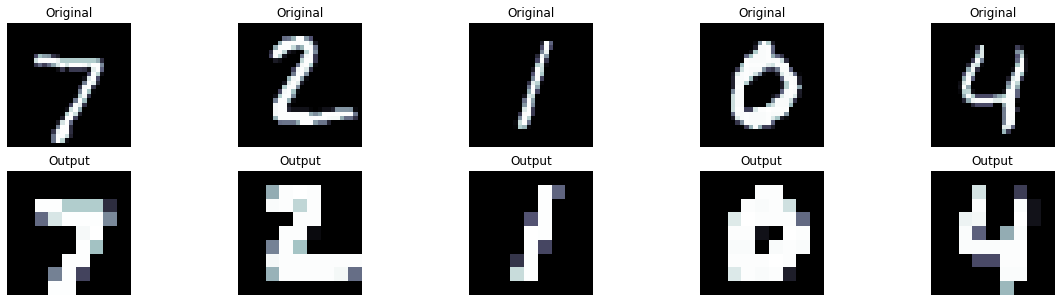

In [17]:
pooled_images = F.max_pool2d(images, kernel_size=3)
print("Size of Original Image:", images[0].shape)
print("Size of Filtered Image:", pooled_images[0].shape)
plot_filter(images, pooled_images)



This is basically it! We now know what these elementary operations (filtering and pooling) mean in the context of convnets.

In essence, the forward pass of any convolutional network (however deep) involves some combination of filtering and pooling operations as discussed above, interspersed with nonlinear (pixel-wise) activations, Sometimes possibly other types of pointwise operations such as batch-norm or drop-out are used, but the conv operations are the key.

The crucial difference, of course, is that **in convnets, the filter weights are not a priori set by hand (as we did in the above examples) but rather incrementally learned from data using back-propagation.**

A fun resource for playing around with convolutions: https://generic-github-user.github.io/Image-Convolution-Playground/src/
